# Box - Jenkins

La metodología de los modelos ARIMA fué formalizada por Box y Jenkins en 1976, por lo que también se les denomina modelos Box - Jenkins.

El acrónimo ARIMA significa media móvil(MA) integrada(I) autorregresiva(AR).

Los retrasos de las series estacionarias en la ecuación de pronóstico se denominan términos “autorregresivos”, los retrasos de los errores de pronóstico se denominan términos de “promedio móvil” y se dice que una serie de tiempo que debe diferenciarse para hacerse estacionaria es “integrada” versión de una serie estacionaria.

**Modelos especiales**

Los modelos de caminata aleatoria y de tendencia aleatoria, los modelos autorregresivos y los modelos de suavizado exponencial son casos especiales de los modelos ARIMA.

Un modelo ARIMA no estacional se clasifica como un modelo “ARIMA (*p, d, q*)” donde:
- p es el número de términos autorregresivos
- d es el número de diferencias no estacionales necesarias para la estacionariedad
- q es el número de errores de pronóstico rezagados en la ecuación de predicción

**AR**

Un modelo autorregresivo es simplemente una regresión lineal del valor actual de la serie contra uno o más valores anteriores de la serie. El valor de p es el orden del modelo AR.

Los modelos AR se pueden analizar con uno de varios métodos, incluidas las técnicas estándar de mínimos cuadrados lineales. También tienen una interpretación directa.

**MA**

Un modelo de promedio móvil (MA) es conceptualmente una regresión lineal del valor actual de la serie contra el ruido blanco o choques aleatorios de uno o más valores anteriores de la serie. Se supone que los choques aleatorios en cada punto provienen de la misma distribución, típicamente una distribución normal, con ubicación en cero y escala constante. La distinción en este modelo es que estos choques aleatorios se propagan a valores futuros de las series de tiempo. Ajustar las estimaciones de MA es más complicado que con los modelos AR porque los términos de error no son observables.

<img src="box-jenkins.jpg">

## Supuestos del modelo ARIMA

- Los datos deben ser estacionarios; por estacionario, significa que las propiedades de la serie no dependen del momento en que se capturan. Una serie de ruido blanco y series con comportamiento cíclico también pueden considerarse como series estacionarias.

- Los datos deben ser univariados: ARIMA funciona en una sola variable. La regresión automática tiene que ver con la regresión con los valores pasados.

## Pasos a seguir para el modelado ARIMA:

1. Identificación del Modelo.

2. Ajustar el modelo.

3. Diagnostico del modelo.

4. Pronósticos.

In [1]:
#Importación de paquetes
import warnings
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pd.plotting.register_matplotlib_converters()
from scipy.stats import boxcox
from scipy import stats
import yfinance as yf
yf.pdr_override()
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr

warnings.filterwarnings("ignore")

## 1. ¿Es estacionaria?

El primer paso en la identificación del modelo es determinar si la serie es estacionaria, es decir, si la serie de tiempo parece variar alrededor de un nivel fijo. Es útil observar una gráfica de la serie junto con la función de autocorrelación de la muestra.

In [2]:
with open('trial.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df

,date,1. open,filtered open
0,2012-05-25,36.530,36.530
1,2012-06-01,31.480,31.480
2,2012-06-08,27.200,27.200
3,2012-06-15,27.180,27.180
4,2012-06-22,29.955,29.955
...,...,...,...
401,2020-01-31,213.100,213.100
402,2020-02-07,203.440,203.440
403,2020-02-14,211.520,211.520
404,2020-02-21,213.550,213.550


In [4]:
df.rename(columns = {"1. open" : "open"}, inplace = True)
df.drop(columns = 'filtered open', inplace = True)

In [5]:
df.head()

,date,open
0,2012-05-25,36.530
1,2012-06-01,31.480
2,2012-06-08,27.200
3,2012-06-15,27.180
4,2012-06-22,29.955


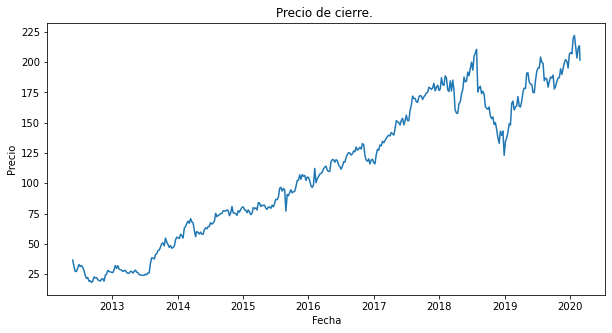

In [6]:
#Visualización
plt.figure(figsize=(10,5)) 
plt.plot(df['date'], df['open'])
plt.title("Precio de cierre. ")
plt.ylabel("Precio")
plt.xlabel("Fecha")
plt.show()

El grafico indica cambios en el nivel de la serie así como tendencia, por tanto, es **no estacionaria**.

## 2. Gráficos de autocorrelación y autocorrelación parcial

La autocorrelación es una medida de qué tanto se relaciona una variable anterior con respecto a la misma variable con un desfase. Es la relación de su valor presente con un valor pasado.

La autocorrelación parcial es lo mismo pero sólo muestra los efectos de cada retraso manteniendo un control sobre las demás variables. (Qué efectos tiene una sola variable dado que todo lo demás es constante).

In [7]:
#Dividir set
test_sample = 30
train_df = df.iloc[:(df.shape[0] - test_sample),:]
test_df = df.iloc[(df.shape[0] - test_sample):,:]
print(train_df.shape, test_df.shape)

(376, 2) (30, 2)


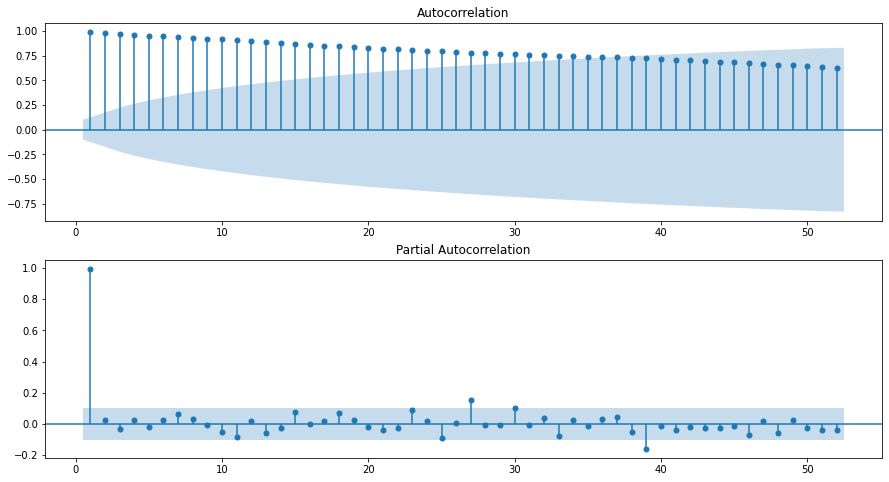

In [8]:
# Visualizar las correlaciones

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))

plot_acf(train_df['open'], lags=52, zero=False, ax=ax1)

plot_pacf(train_df['open'], lags=52, zero=False, ax=ax2)
plt.show()

| date | close | close_1 (lag1) | close_2 (lag2) |
| --------- | --------- | --------- | --------- |
| 2020 - 03 - 18 | 147 | 138 | 125 |
| 2020 - 03 - 19 | 148 | 147 | 138 |
| 2020 - 03 - 20 | 150 | 148 | 147 |

La sombra azul es el intervalo de confianza, si un valor de autocorrelación cae dentro del intervalo se considera 0.

**¿Que información nos da el gráfico?**

El orden del modelo MA (Moving Average) se define como el número de lag anterior en el cuál la autocorrelación entre al intervalo de confianza (Son 34 variables las que se deberían considerar para una buena predicción).

Como se muestra en el gráfico, la autocorrelación continúa disminuyendo a medida que aumenta el retraso, lo que confirma que no existe una asociación lineal entre las observaciones separadas por retrasos más grandes.

El orden del modelo autorregresivo (AR) se define por el número de lag anterior a que la autocorrelación parcial entre al intervalo de confianza. (Es 1 en este caso)

La forma del gráfico de la autocorrelación indica que la serie muy probablemente no sea estacionaria, debido a que los parámetros están decayendo lentamente; sin embargo, esta es una deducción visual y faltaría comprobarlo con el uso de una prueba estadística.

## 3. Prueba de Dickey - Fuller

Una serie que cumpla con tener una media y una varianza que no dependa del tiempo se le conoce como una serie estacionaria. 

Verificar esto permite que se puedan aplicar los modelos (AR) y (MA) ya que este es un supuesto clave en la construcción y derivación de estos modelos.

La prueba de estacionalidad de la media se le conoce como la **prueba Dickey-Fuller**.

En un simple modelo autorregresivo de orden (1):

$\mathrm y_{t}=\rho y_{t-1}+u_{t}\,$

Donde:

- $y_{t}$ es la variable de interés
- $t$ es el índice de tiempo
- $\rho$ es un coeficiente
- $u_{t}$ es el término de error.

La raíz unitaria está presente si ρ = 1. En este caso, el modelo no sería estacionario.

$\mathrm{H}_0:$ La serie es no estacionaria.

$\mathrm{H}_1:$ La serie es estacionaria

Si p-value > 0.05 la serie no es estacionaria

Si p-value < 0.05 la serie es estacionaria

In [9]:
# Test de Dicky-Fuller
result = adfuller(train_df['open'])

# Test estadístico
print('Estadístico ADF: ', result[0])

# p-value
print('p-value: ', result[1])

#print(result)

Estadístico ADF:  -0.2889158359031389
p-value:  0.927059577134772


En este caso la serie no es estacionaria dado que la media si está cambiando con respecto al tiempo (una tendencia a la alza), existen métodos que permiten convertir una serie no estacionaria a una que si lo es, utilizando la diferenciación (en lugar de analizar el precio de la acción, analizamos el cambio de precio de la acción).

En muchos casos, una sola diferenciación suele ser suficiente para convertir a una serie en estacionaria.

In [10]:
result = adfuller(train_df['open'].diff(1).dropna())

# Test estadístico
print('Estadístico ADF: ', result[0])

# p-value
print('p-value: ', result[1])

#print(result)

Estadístico ADF:  -21.87394584756823
p-value:  0.0


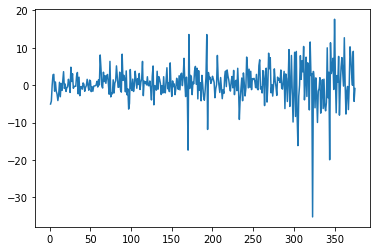

In [11]:
plt.plot(train_df['open'].diff(1).dropna())
plt.show()

El valor p disminuyó. El hecho de aplicar una diferencia a la serie permitió que esta cambiara de una no estacionaria a una estacionaria (asumiendo $\alpha = 0.05$). 



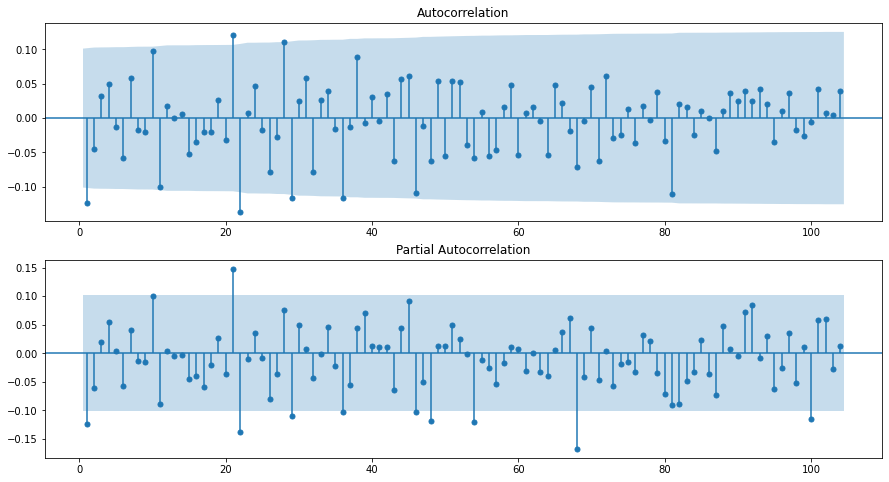

In [12]:
# Graficar nuevamente los coeficientes de autocorrelacion y autocorrelación parcial

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))

plot_acf(train_df['open'].diff(1).dropna(), lags=104, zero=False, ax=ax1)

plot_pacf(train_df['open'].diff(1).dropna(), lags=104, zero=False, ax=ax2)

plt.show()

#Tenemos la propuesta que el mejor modelo tiene orden MA (1), AR(0) con 1 grado de diferenciación.

Una vez que se ha obtenido una serie estacionaria, debemos identificar la forma del modelo que se utilizará.

La identificación de la forma del modelo se lleva a cabo comparando las autocorrelaciones y las autocorrelaciones parciales calculadas con los datos de la autocorrelaciones y las autocorrelaciones parciales teóricas de los diferentes modelos ARIMA.

### En resumen... 

Un modelo ARIMA no estacional se clasifica como un modelo “ARIMA (p, d, q)” donde:

- p es el número de términos autorregresivos
- d es el número de diferencias no estacionales necesarias para la estacionariedad
- q es el número de errores de pronóstico rezagados en la ecuación de predicción

La AC y PAC se utilizan para estimar de forma inicial los parámetros que se pueden usar en el modelo.

- Número de retrasos que se van a usar (valores $a$ de AR)
\begin{align}
y(t_n) = a_0 + a_1 y(t_{n-1}) + a_2y(t_{n-2}) + .... a_m y(t_{n-m})
\end{align}


- Número de valores de residuos a usar (valores $\theta$ de MA)

\begin{align}
y(t) = \mu + \theta_0 \epsilon_t + \theta_1 \epsilon_{t-1} + ... \theta_m \epsilon_{t-m}
\end{align}

Con las gráficas de la autocorrelación y la autocorrelación parcial podemos ver los términos significativos, los valores de ACs son los $theta$ de MA y los valores de PACs son los valores $a$ de AR.

# Modelo ARMA o ARIMA

Los gráficos de autocorrelación parcial o total se pueden utilizar para seleccionar el número de parámetros del modelo AR o MA. ¿Cuál de los 2 conviene usar? Es posible utilizar ambos para obtener un modelo más robusto, el modelo **ARMA (p,q)** en donde p es el orden de retrasos utilizados y q es el orden de residuos que se consideran en el análisis.

Los modelos AR y MA sólo aplican en series estacionarias, por lo que tendrían que ajustarse a la diferencia de los precios del activo. Calcular la diferencia, ajustar y posteriormente integrar los resultados de nuevo resulta tedioso, para esto se puede utilizar un modelo **ARIMA** (La I es de "Integración).

Un modelo **ARIMA(p, d, q)** cuenta con 3 parámetros, 2 son los mismos que en el modelo ARMA. El único diferente es el término *d* que establece cuantas veces se necesita diferenciar la serie para que esta sea estacionaria.

In [29]:
# Primero se entrena el modelo

p = 1 #(AR se obtiene de PAC)
d = 1 # Orden de la diferencia. En caso de que no sea una serie estacional y debamos aplicar diferencia en la serie de datos.
q = 0 #(MA se obtiene de AC)

model = SARIMAX(train_df['open'], order=(p,d,q), trend='c')

# Trend con c es obligatorio cuando no está centrada en 0 la serie temporal

In [30]:
# Entrenamos al modelo
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   open   No. Observations:                  376
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1099.980
Date:                Tue, 06 Jul 2021   AIC                           2205.960
Time:                        09:37:52   BIC                           2217.741
Sample:                             0   HQIC                          2210.637
                                - 376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4890      0.255      1.918      0.055      -0.011       0.989
ar.L1         -0.1235      0.045     -2.725      0.006      -0.212      -0.035
sigma2        20.6691      0.647     31.963      0.0

Los valores $p$ son los valores de significancia, es decir, la probabilidad de que ese valor no sea real. Si el $p-value$ es menor a 0.5, entonces es significativo. (Con $a$ = 0.5)

**ar.L2** no es significativo...

In [31]:
# Genera predicciones
one_step_forecast = results.get_prediction(start = 350, end = 400)

# Hace forecasting de la media
mean_forecast = one_step_forecast.predicted_mean

# Intervalos de confianza
confidence_intervals = one_step_forecast.conf_int()

# Seleccion de los extremos de los intervalos de confianza.
lower_limits = confidence_intervals.loc[:,'lower open']
upper_limits = confidence_intervals.loc[:,'upper open']

ar_value_forecast = results.get_forecast(steps=30).predicted_mean

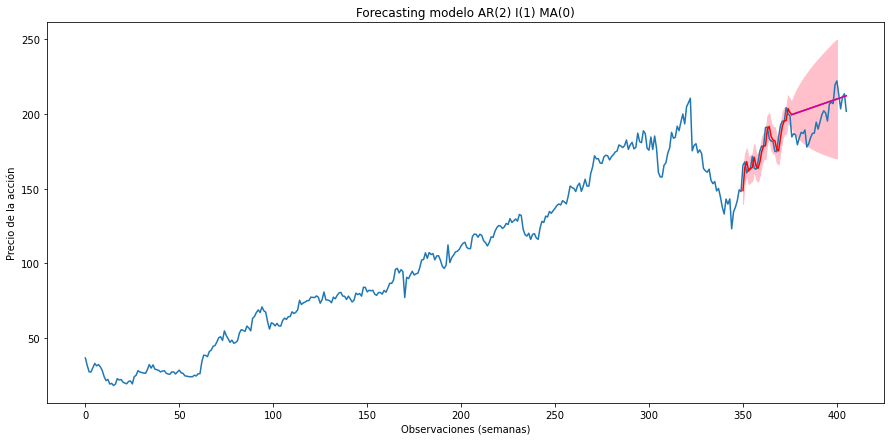

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

plt.plot(df.index, df['open'], label='reales')
plt.plot()

plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')


plt.plot(ar_value_forecast.index, ar_value_forecast)

ar_value_forecast.plot(color='m')

plt.title("Forecasting modelo AR(2) I(1) MA(0)")
plt.xlabel("Observaciones (semanas)")
plt.ylabel("Precio de la acción")
#shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

plt.show()

## ¿Pronóstico?

El método de Box - Jenkins nos dice que se debe verificar que:

- Estacionariedad de los residuos
- Normalidad de los residuos
- Los residuos no estén correlacionados
- Los parámetros sean significativos

Para la normalidad de los residuos:

El diagrama Q-Q de los residuos del modelo ARIMA estimado para la serie se muestra abajo. Los puntos parecen seguir la línea recta bastante de cerca. Este gráfico no nos llevará a rechazar la normalidad de los términos de error en este modelo.

Además, la prueba de normalidad de Shapiro-Wilk.

**Prueba de Shapiro-Wilk**

$\mathrm{H}_0:$ Los datos tienen distribución normal.

$\mathrm{H}_1:$ Los datos no tienen distribución normal.

Si p-value > 0.05 es normal

Si p-value < 0.05 no es normal

In [23]:
result = stats.shapiro(results.resid)

print('p-value: ', result[1])

p-value:  7.30251795169217e-19


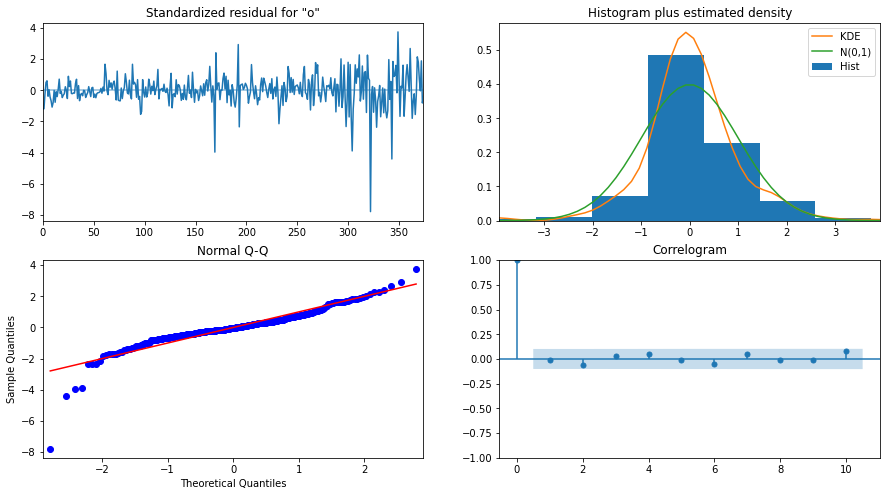

In [24]:
#Visualización de resultados
results.plot_diagnostics(figsize=(15,8))
plt.show()

En el correlograma se puede observar que no existen residuos correlacionados.

¿Terminamos? NO...